<a href="https://colab.research.google.com/github/MartynaPlomecka/AI4Health/blob/main/autoenc_on_spectras_on_fixed_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov  8 22:47:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [8]:
import scipy.io
from matplotlib import pyplot
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from pandas import read_csv
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score

In [9]:
data = scipy.io.loadmat('x.mat')
columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(data['x'].shape[1]) for j in range(data['x'].shape[2])])
data['x'].shape
columns

array([['Electrode 1 - 1/2 Hz'],
       ['Electrode 1 - 2/2 Hz'],
       ['Electrode 1 - 3/2 Hz'],
       ...,
       ['Electrode 105 - 77/2 Hz'],
       ['Electrode 105 - 78/2 Hz'],
       ['Electrode 105 - 79/2 Hz']], dtype='<U23')

In [10]:
labels = pd.read_csv("table_withlabels.csv")
foof = pd.read_csv("foof2features.csv")
beh = pd.read_csv("behaviorals.csv")

In [11]:
df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))
df.columns = columns
df['IDs'] = foof['C1']

In [12]:
df2 = pd.merge(df, labels[['label', 'IDs']], on='IDs', how='inner')
df2

,"(Electrode 1 - 1/2 Hz,)","(Electrode 1 - 2/2 Hz,)","(Electrode 1 - 3/2 Hz,)","(Electrode 1 - 4/2 Hz,)","(Electrode 1 - 5/2 Hz,)","(Electrode 1 - 6/2 Hz,)","(Electrode 1 - 7/2 Hz,)","(Electrode 1 - 8/2 Hz,)","(Electrode 1 - 9/2 Hz,)","(Electrode 1 - 10/2 Hz,)","(Electrode 1 - 11/2 Hz,)","(Electrode 1 - 12/2 Hz,)","(Electrode 1 - 13/2 Hz,)","(Electrode 1 - 14/2 Hz,)","(Electrode 1 - 15/2 Hz,)","(Electrode 1 - 16/2 Hz,)","(Electrode 1 - 17/2 Hz,)","(Electrode 1 - 18/2 Hz,)","(Electrode 1 - 19/2 Hz,)","(Electrode 1 - 20/2 Hz,)","(Electrode 1 - 21/2 Hz,)","(Electrode 1 - 22/2 Hz,)","(Electrode 1 - 23/2 Hz,)","(Electrode 1 - 24/2 Hz,)","(Electrode 1 - 25/2 Hz,)","(Electrode 1 - 26/2 Hz,)","(Electrode 1 - 27/2 Hz,)","(Electrode 1 - 28/2 Hz,)","(Electrode 1 - 29/2 Hz,)","(Electrode 1 - 30/2 Hz,)","(Electrode 1 - 31/2 Hz,)","(Electrode 1 - 32/2 Hz,)","(Electrode 1 - 33/2 Hz,)","(Electrode 1 - 34/2 Hz,)","(Electrode 1 - 35/2 Hz,)","(Electrode 1 - 36/2 Hz,)","(Electrode 1 - 37/2 Hz,)","(Electrode 1 - 38/2 Hz,)","(Electrode 1 - 39/2 Hz,)","(Electrode 1 - 40/2 Hz,)",...,"(Electrode 105 - 42/2 Hz,)","(Electrode 105 - 43/2 Hz,)","(Electrode 105 - 44/2 Hz,)","(Electrode 105 - 45/2 Hz,)","(Electrode 105 - 46/2 Hz,)","(Electrode 105 - 47/2 Hz,)","(Electrode 105 - 48/2 Hz,)","(Electrode 105 - 49/2 Hz,)","(Electrode 105 - 50/2 Hz,)","(Electrode 105 - 51/2 Hz,)","(Electrode 105 - 52/2 Hz,)","(Electrode 105 - 53/2 Hz,)","(Electrode 105 - 54/2 Hz,)","(Electrode 105 - 55/2 Hz,)","(Electrode 105 - 56/2 Hz,)","(Electrode 105 - 57/2 Hz,)","(Electrode 105 - 58/2 Hz,)","(Electrode 105 - 59/2 Hz,)","(Electrode 105 - 60/2 Hz,)","(Electrode 105 - 61/2 Hz,)","(Electrode 105 - 62/2 Hz,)","(Electrode 105 - 63/2 Hz,)","(Electrode 105 - 64/2 Hz,)","(Electrode 105 - 65/2 Hz,)","(Electrode 105 - 66/2 Hz,)","(Electrode 105 - 67/2 Hz,)","(Electrode 105 - 68/2 Hz,)","(Electrode 105 - 69/2 Hz,)","(Electrode 105 - 70/2 Hz,)","(Electrode 105 - 71/2 Hz,)","(Electrode 105 - 72/2 Hz,)","(Electrode 105 - 73/2 Hz,)","(Electrode 105 - 74/2 Hz,)","(Electrode 105 - 75/2 Hz,)","(Electrode 105 - 76/2 Hz,)","(Electrode 105 - 77/2 Hz,)","(Electrode 105 - 78/2 Hz,)","(Electrode 105 - 79/2 Hz,)",IDs,label
0,7.707834e-12,1.512286e-10,2.475735e-09,3.453763e-08,4.554996e-07,0.000007,0.000109,0.001314,0.009992,0.045200,0.121630,0.205934,0.263955,0.354726,0.545805,0.795967,0.989854,1.027207,0.887269,0.637793,0.381529,0.189932,0.078685,2.712743e-02,7.783476e-03,1.862060e-03,3.942583e-04,1.977762e-04,6.257702e-04,2.305441e-03,7.111082e-03,1.813943e-02,3.825323e-02,6.669673e-02,0.096172,0.114774,0.113667,0.094283,0.067737,0.047193,...,4.607796e-02,3.274256e-02,2.406225e-02,1.763925e-02,1.271035e-02,8.968245e-03,6.191920e-03,4.182827e-03,2.764631e-03,1.787832e-03,1.131198e-03,7.002814e-04,4.241593e-04,0.000251,0.000146,0.000083,0.000046,0.000025,0.000013,0.000007,0.000004,0.000002,8.488273e-07,4.044092e-07,1.885146e-07,8.597876e-08,3.836717e-08,1.675138e-08,7.155891e-09,2.990881e-09,1.223086e-09,4.893694e-10,1.915752e-10,7.337775e-11,2.749867e-11,1.008282e-11,3.617107e-12,1.269651e-12,NDARAA075AMK,No Diagnosis Given
1,3.798713e-02,1.639433e-01,2.897591e-01,2.097609e-01,6.347556e-02,0.027758,0.105298,0.184513,0.130638,0.163258,0.175982,0.191296,0.163549,0.165213,0.196133,0.183649,0.118244,0.051315,0.014980,0.002941,0.000388,0.000034,0.000002,8.280853e-08,2.879210e-09,3.045984e-08,1.168140e-06,2.824546e-05,4.166383e-04,3.732538e-03,2.029281e-02,6.694483e-02,1.340280e-01,1.629914e-01,0.121013,0.056922,0.022720,0.020140,0.034753,0.060380,...,2.199757e-01,2.263200e-01,2.260933e-01,2.196382e-01,2.081037e-01,1.944374e-01,2.205731e-01,2.351404e-01,1.587448e-01,1.481614e-01,1.462097e-01,1.457914e-01,1.438203e-01,0.137472,0.125241,0.107495,0.086270,0.064431,0.044651,0.028662,0.017027,0.009358,4.758187e-03,2.240159e-03,9.778570e-04,3.967077e-04,1.501681e-04,5.337634e-05,1.799164e-05,5.835291e-06,1.856717e-06,5.922864e-07,1.928109e-07,6.449918e-08,2.204650e-08,7.598678e-09,2.604260e-09,8.780452e-10,NDAR

In [13]:
print(df2['label'].value_counts())

Other Neurodevelopmental Disorders    492
ADHD-Inattentive Type                 388
ADHD-Combined Type                    376
Anxiety Disorders                     241
No Diagnosis Given                    203
Depressive Disorders                   85
Name: label, dtype: int64


In [14]:
df2.shape

(1785, 8297)

In [15]:
X = df2[df2.columns.difference(['IDs', 'label'])]
y = df2['label']
print(X.shape)
y.shape

(1785, 8295)


(1785,)

In [16]:
# number of input columns
n_inputs = X.shape[1]
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

Epoch 1/50
75/75 - 7s - loss: 0.4754 - val_loss: 0.8414
Epoch 2/50
75/75 - 5s - loss: 0.0617 - val_loss: 0.1130
Epoch 3/50
75/75 - 5s - loss: 0.0653 - val_loss: 0.2263
Epoch 4/50
75/75 - 5s - loss: 0.0846 - val_loss: 0.0700
Epoch 5/50
75/75 - 5s - loss: 0.0606 - val_loss: 0.0631
Epoch 6/50
75/75 - 5s - loss: 0.0700 - val_loss: 0.1272
Epoch 7/50
75/75 - 5s - loss: 0.2276 - val_loss: 3.1113
Epoch 8/50
75/75 - 5s - loss: 0.5505 - val_loss: 0.1788
Epoch 9/50
75/75 - 5s - loss: 0.0325 - val_loss: 0.0592
Epoch 10/50
75/75 - 5s - loss: 0.0270 - val_loss: 0.0268
Epoch 11/50
75/75 - 5s - loss: 0.0295 - val_loss: 0.0646
Epoch 12/50
75/75 - 5s - loss: 0.0315 - val_loss: 0.0345
Epoch 13/50
75/75 - 5s - loss: 0.0305 - val_loss: 0.0263
Epoch 14/50
75/75 - 5s - loss: 0.0261 - val_loss: 0.0428
Epoch 15/50
75/75 - 5s - loss: 0.0306 - val_loss: 0.0282
Epoch 16/50
75/75 - 5s - loss: 0.0358 - val_loss: 0.0601
Epoch 17/50
75/75 - 5s - loss: 0.0362 - val_loss: 0.0360
Epoch 18/50
75/75 - 5s - loss: 0.0326 - 

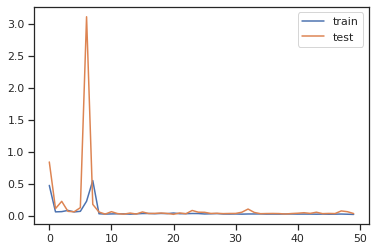

In [17]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = round(float(n_inputs) / 5.0)
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=50, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

In [26]:
# define model 1
model = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=0)
# fit model on training set
model.fit(X_train, y_train)
# make prediction on test set
yhat = model.predict(X_test)
# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

KeyboardInterrupt: ignored

In [19]:
model2 = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
model2.fit(X_train, y_train)
preds = model2.predict(X_test)
acc = accuracy_score(y_test, yhat)
print(acc)

0.18983050847457628


In [ ]:
# evaluate logistic regression on encoded input
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
# define dataset
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# load the model from file
encoder= load_model('encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
model = svm.SVC(decision_function_shape='ovo')
# fit the model on the training set
model.fit(X_train_encode, y_train)
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)